# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


In [2]:
!pip install torchinfo

In [29]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


---
### Задача 1. Классификация MNIST


Цель: сравним сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Классификация MNIST намного легче, чем CIFAR, поэтому наша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

Загрузим датаcет из `torchvision.datasets`.

In [30]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

100%|██████████| 9912422/9912422 [00:00<00:00, 168615576.22it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38116958.41it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49008903.35it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5110120.38it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Визуализируем несколько картинок с соответствующими метками из датасета.

Проверим размеры датасетов.

In [31]:
len(train_dataset), len(val_dataset)

(60000, 10000)

Размер картинки: torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

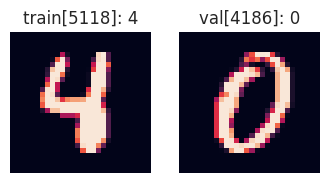

In [32]:
# берем два рандомных индекса
train_idx, val_idx = np.random.randint(0, 10000, 2)
print(f"Размер картинки: {train_dataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f"train[{train_idx}]: {classes[train_dataset[train_idx][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f"val[{val_idx}]: {classes[val_dataset[val_idx][1]]}")
plt.axis("off")

Создадим генераторы батчей.

Поскольку данных очень много, будем тренировать модель постепенно, используя батчи. Создадим для них генератор.

In [33]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Запишем функции для обучения модели

In [34]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

In [44]:
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "magenta"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
      if i == 0:
        legend = axs[i].legend(loc=9)
        axs[i].legend(dummy_lines, ["train", "val"], loc=1)
      if i == 1:
        legend = axs[i].legend(loc=8)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
      axs[i].add_artist(legend)
    plt.show()

**Эксперимент 1.** Создадим 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

1 нейросеть:
* 2 сверточных слоя
* 1 линейный слой

2 нейросеть: 
* 1 сверточный слой
* 2 линейных слоя

3 нейросеть: 
* 2 сверточных слоя
* 2 линейных слоя

4 нейросеть: 
* 3 сверточных слоев
* 2 линейных слоя

5 нейросеть: 
* 2 сверточных слоя
* 3 линейных слоев

In [36]:
model1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=10),
).to(device)

model2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=2704, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10),
).to(device)

model3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=2304, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=128, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [37]:
models = [model1, model2, model3, model4, model5]

for i in range(len(models)):
  print(summary(models[i], input_size=(1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 10]                   16,010
Total params: 34,826
Trainable params: 34,826
Non-trainable params: 0
Total mult-adds (M): 2.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.14
Estimated Total Size (MB): 0.38
Layer (type:depth-idx)                   Output Shape              Param #


Обучим сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [38]:
criterion = nn.CrossEntropyLoss()
optimizers = [torch.optim.Adam(models[i].parameters()) for i in range(len(models))]

histories = [train(
    models[i],
    criterion,
    optimizers[i],
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
) for i in range(len(models))]
# Сохраняем веса модели в файл
[torch.save(models[i].state_dict(), f"model{i}.pth") for i in range(len(models))]

Epoch 10 of 10 took 10.596 s
  training loss: 	0.009584
  validation loss: 	0.032372
  training accuracy: 			99.72 %
  validation accuracy: 			99.13 %


[None, None, None, None, None]

Постройм график лосса и график accuracy, где сравниваются все модели (на train и на val).

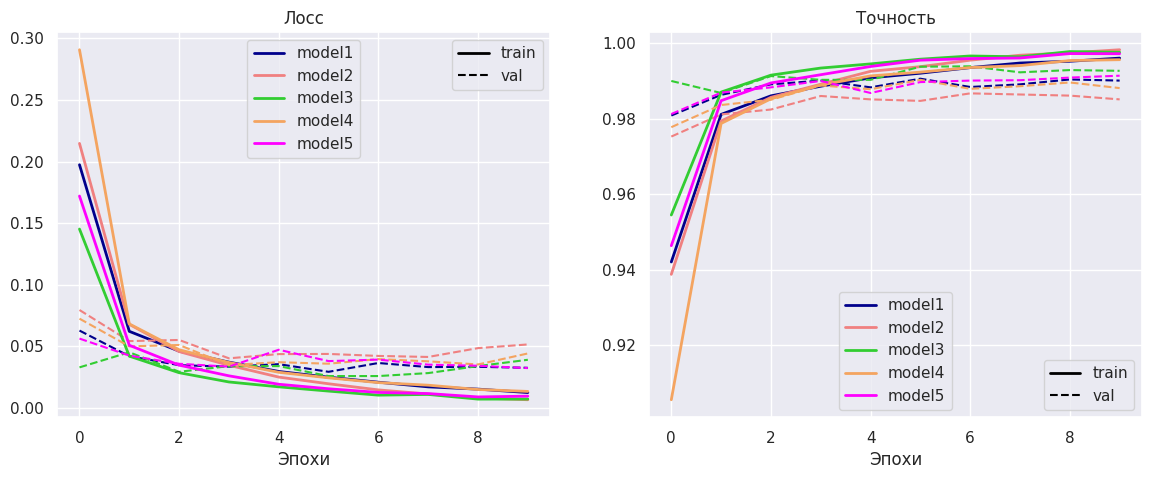

In [45]:
names = ["model1", "model2", "model3", "model4", "model5"]
plot_histories(histories, names)

Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:** \\
Из эксперимента видно, что лучшие показатели у 3 модели: сверточными слоями было выявлено достаточное количество ключевых признаков.

* При увеличении слоев нейронной сети точность предсказаний растет. Однако необходимо следить, чтобы размерность матрицы в ходе обучения не падала слишком сильно (как в `model4`): это приводит к обучению на очень маленьком количестве признаков.
* Важно помнить, что слишком большая модель для легких задач не принесет большого выигрыша в точности, но потребует много ресурсов.
* Можно заметить интересный эффект на графике справа. Точность на *train* датасете растет, когда как на тестовом перестает улучшаться. Это говорит о переобучении нейросети.

**Эксперимент 2.** Теперь выберем лучший вариант, зафиксируем количество сверточных и линейных слоев и обучим хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток.

In [41]:
model3_mod1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model3_mod2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=4096, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model3_mod3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=4096, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model3_mod4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=2304, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

mods = [model3_mod1, model3_mod2, model3_mod3, model3_mod4]

Построим график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

In [42]:
criterions = [nn.CrossEntropyLoss() for _ in range(len(mods))]
optimizers_mods = [torch.optim.Adam(mods[i].parameters()) for i in range(len(mods))]

histories_mods = [train(
    mods[i],
    criterions[i],
    optimizers_mods[i],
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
) for i in range(len(mods))]
# Сохраняем веса модели в файл
[torch.save(mods[i].state_dict(), f"mod{i}.pth") for i in range(len(mods))]

Epoch 10 of 10 took 10.799 s
  training loss: 	0.008685
  validation loss: 	0.038993
  training accuracy: 			99.71 %
  validation accuracy: 			98.99 %


[None, None, None, None]

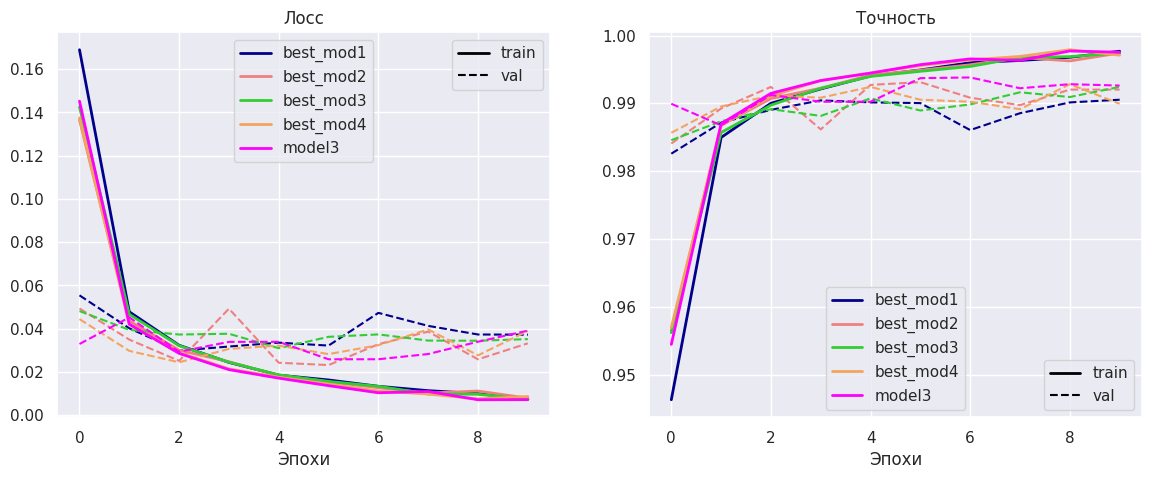

In [48]:
histories_mods.append(histories[2])
names = ["best_mod1", "best_mod2", "best_mod3", "best_mod4", "model3"]
plot_histories(histories_mods, names)

Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:**
* сильного увеличения точности мы не добились: под конец графики практически совпадают
* `best_mod1`. Эта модификация показала худшие результаты. Возможно, это связано с недостаточным размером ядра для первого сверточного слоя, с невозможностью выцепить важные зависимости.
* `best_mod2` и `best_mod4` показали одинаковые результаты как входе обучения, так и входе предсказания. Их отличительной чертой являются большие размеры ядра на входе.
* `best_mod3` показала лучшие результаты входе предсказаний. Это может говорить о том, что размеры ядер в слоях должны не сильно отличаться друг от друга.

**Анализ лучшей модели.** Выберем лучшую конфигурацию из всех по accuracy на валидации.

In [49]:
final = torch.load('mod2.pth')
model3_mod3.load_state_dict(final)
model3_mod3.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=4096, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=10, bias=True)
)

Проведем еще один проход валидации выбранной моделью по всему датасету. В нем посчитаем точность по каждому классу и соберем информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажем 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

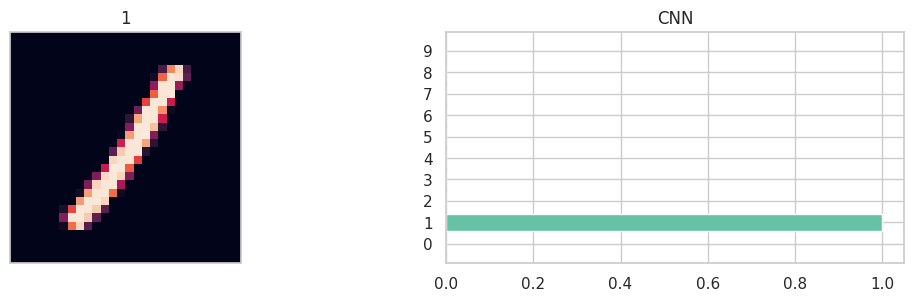

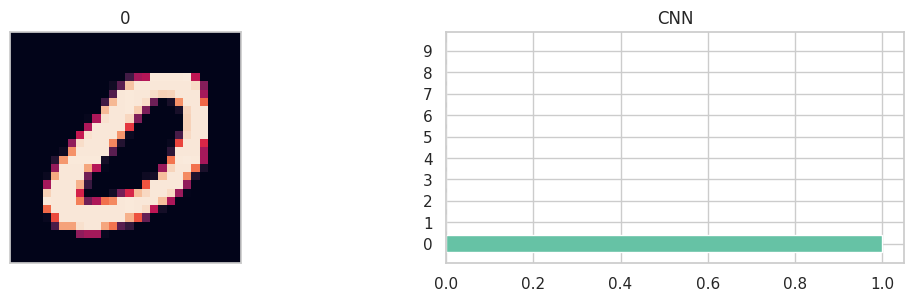

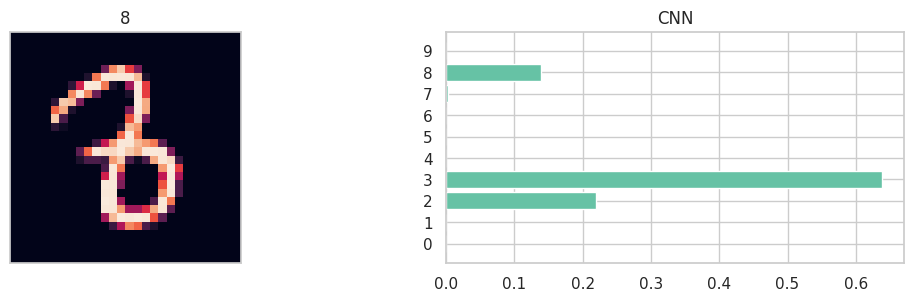

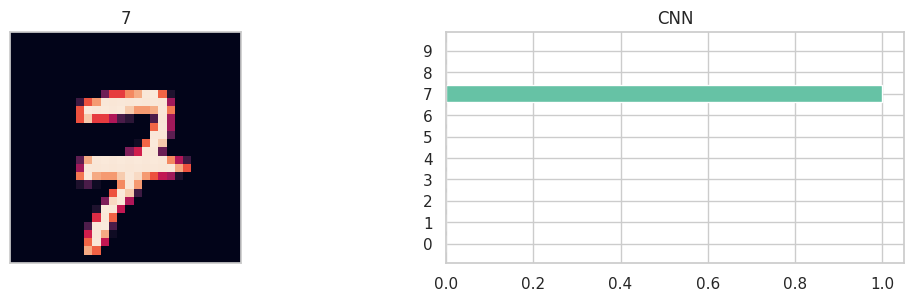

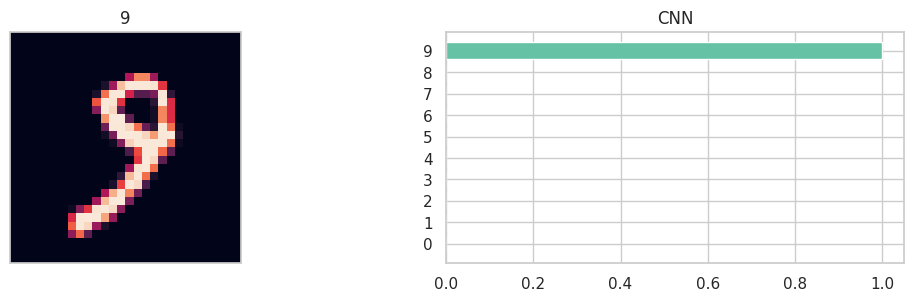

In [52]:
for i in np.random.randint(0, len(val_dataset), 5):
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(13, 3))

        # Достаем 1 рандомный объект из тестового датасета
        image, label = val_dataset[i]

        plt.subplot(1, 2, 1)
        plt.imshow(image.permute((1, 2, 0)))
        plt.title(f"True: {classes[label]}. Predicted{}")
        plt.xticks([])
        plt.yticks([])

        # Не забываем выключить градиенты на момент вычислений
        with torch.no_grad():
            logits_cnn = model3_mod3(image.to(device).unsqueeze(0))[0].cpu()

        # Чтобы логиты перевести в вероятности применяем softmax по оси классов
        prob_cnn = torch.softmax(logits_cnn, dim=0)

        plt.subplot(1, 2, 2)
        plt.barh(classes, prob_cnn)
        plt.title("CNN")

**Ответ:** Видим, что модель ошибается в сложных ситуациях, где линия обрывается (например, с цифрой 8). Можно предположить, что свою роль в предсказании может сыграть толщина линии или необычность почерка.

**Вывод по всей задаче:** \
Данная задача позволила погрузиться в сверточные нейронные сети и их применение при распознавании образов, добившись точности в 98%, и переносе стиля. \
При сравнении нескольких моделей мы поняли, что оптимальное количество сверточных слоев равно 3, а линейных - 2. \
На простых задачах не стоит использовать большие модели, так как они требуют больших вычислительных мощностей и при неправильной настройке могут приводить к переобучению. 

От слоя к слою размеры ядра изменять сильно не стоит. Это приводит к выделению не тех признаков. А вот увеличение передаваемых признаков в линейный слой положительно сказывается на результате. 



---
### Задача 2. Перенос стиля

In [17]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set(palette="Set2")

In [18]:
!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225
Receiving objects: 100% (379/379), 92.21 MiB | 31.38 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/Neural-Style-Transfer


Напишем функцию для запуска метода для заданной картинки контента и стиля, а также функцию визуализации результатов.

In [19]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

In [20]:
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = (
        Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    )
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

Запустим Neural Style Transfer на парах контент-стиль.

In [24]:
# подключим Google Drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [25]:
# пути к нужным папкам в Drive
content_path = "/content/drive/MyDrive/DS/style_transfer_images/content"
style_path = "/content/drive/MyDrive/DS/style_transfer_images/style"

# очистим предыдущие картинки, скопируем новые
!rm -r data/content-images
!mkdir data/content-images
!cp -a /$content_path/. data/content-images/

!rm -r data/style-images
!mkdir data/style-images
!cp -a /$style_path/. data/style-images/

In [26]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))
# print(content_images, style_images)
result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=205912817664.0000, content_loss=      0.0000, style loss=205895790000.0000, tv loss=17019848.0000
L-BFGS | iteration: 100, total loss=1223802240.0000, content_loss=606470068.3594, style loss=604860058.5938, tv loss=12472130.0000
L-BFGS | iteration: 200, total loss=786617408.0000, content_loss=530463378.9062, style loss=244602993.1641, tv loss=11551016.0000
L-BFGS | iteration: 300, total loss=695553408.0000, content_loss=498515380.8594, style loss=186118989.2578, tv loss=10919011.0000
L-BFGS | iteration: 400, total loss=656357632.0000, content_loss=482142333.9844, style loss=163839008.7891, tv loss=10376322.0000
L-BFGS | iteration: 500, total loss=634800768.0000, content_loss=472274951.1719, style loss=152598149.4141, tv loss=9927654.0000
L-BFGS | iteration: 600, total loss=621202624.0000, content_loss=465731445.3125, style loss=145900810.5469, tv loss=9570366.0000
L-BFGS | iteration: 700, total loss=61184268

Теперь для каждой пары контекст-стиль попытаемся сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

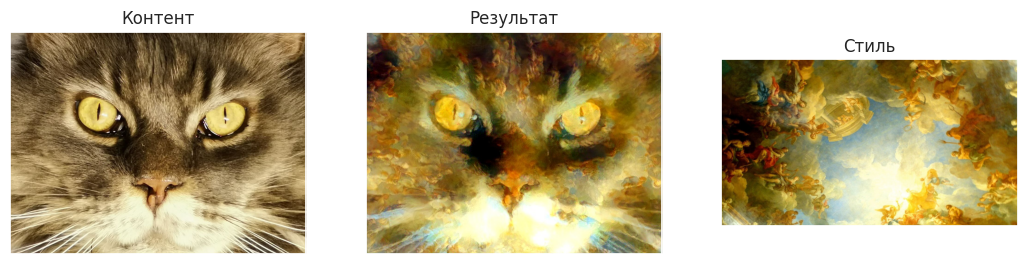

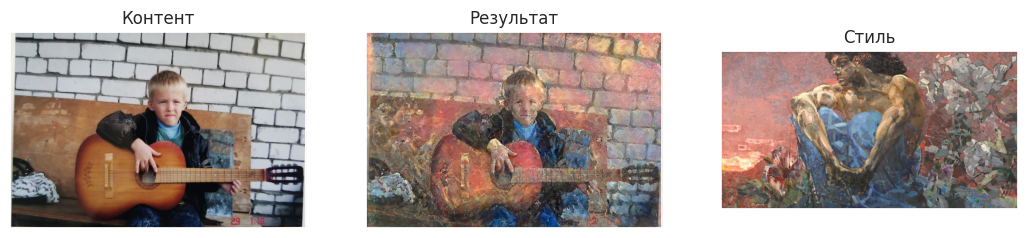

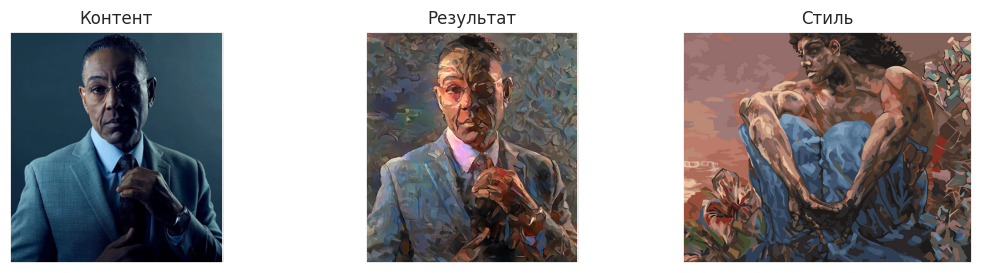

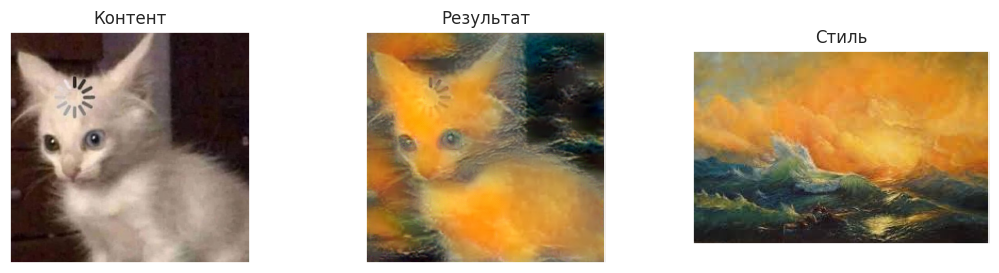

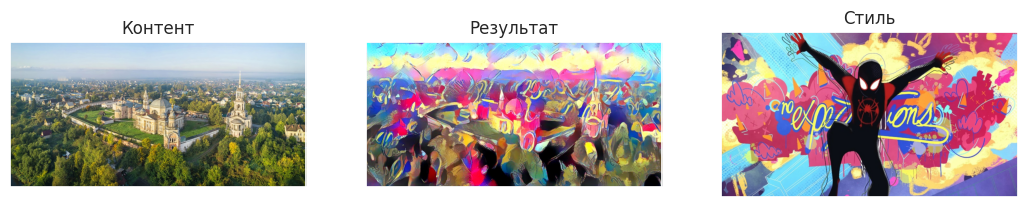

In [28]:
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

**Вывод:** \\
Я убедился, что можно достаточно быстро и несложно перенести стиль одной картинки на другую, при этом важно следить чего в результате будет больше. Например, на последней картинке ожидался перенос лишь цветовой гаммы, но не полного смешивания. В остальном такая модель показала сравнительно неплохие результаты. \\
Итак важно следить за:
* отношением компоненты стиля к компоненте контента
* за размером изображений, чтобы не происходило переполнение памяти